In [144]:
!pip install -Uqq duckduckgo_search
from fastai.vision.all import *

from duckduckgo_search import ddg_images
from time import sleep

import warnings
warnings.filterwarnings('ignore')

The project I will be building is a Guitar Detector, I will create a neural network that descriminate between 7 types of guitars: 
- Fender Stratocaster
- Fender Telecaster
- Gibson Explorer
- Gibson Flying V
- Gibson Les Paul
- Gibson SG
- Super Strat

### Image Classification Workflow
Here is the general workflow I used to solve this image classification problem:
- Step 1: Gather the data
- Step 2: Explore the data
- Step 3: Prepare the data
- Step 4: Build & Train the model
- Step 5: Deploy the model

## Step 1: Gathering the data

Gathering the data is one of the most important step to solve any machine learning problem    
as a model cannot be created without data, and a model can only be good as the data it is built from.

for the problem at hand, the internet is filled with all sort of images that we can use to teach a neural network how to identify guitar types.
let's use the free data on the internet to create a dataset.

In [143]:
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
path = Path('guitars')

if not path.exists():
    path = Path('guitars')
    search_terms = {
        'Fender Stratocaster': ['fender stratocaster guitar', 'stratocaster guitar'],
        'Fender Telecaster': ['fender telecaster guitar', 'telecaster guitar'],
        'Gibson Explorer': ['gibson explorer guitar', 'explorer guitar'],
        'Gibson Flying V': ['gibson flying v guitar', 'flying v guitar'],
        'Gibson Les Paul': ['gibson les paul guitar', 'les paul guitar'],
        'Gibson SG': ['gibson sg guitar', 'sg guitar'],
        'Super Strat': ['super strat guitar', 'super strat hot rod guitar guitar']
    }

    num_images_per_search = 200
    sleep_time_between_searches = 5

    for guitar_type, terms in search_terms.items():
        dest = path/guitar_type
        dest.mkdir(exist_ok=True, parents=True)
        print(f'Downloading {guitar_type}')
        for o in terms:
            download_images(dest, urls=search_images(f'{o} photos'))
            time.sleep(10)  # Pause between searches to avoid over-loading server
        resize_images(path/o, max_size=400, dest=path/o)

we have successfully downloaded images for each type, now let's explore our data.

## Step 2: Explore the data

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [104]:
items = get_image_files(path)

In [105]:
# path = Path('guitars')
# search_terms = {
#     'Fender Stratocaster': ['fender stratocaster guitar', 'stratocaster guitar', 'strat guitar'],
#     'Fender Telecaster': ['fender telecaster guitar', 'telecaster guitar', 'tele guitar'],
#     'Gibson Explorer': ['gibson explorer guitar', 'explorer guitar'],
#     'Gibson Flying V': ['gibson flying v guitar', 'flying v guitar'],
#     'Gibson Les Paul': ['gibson les paul guitar', 'les paul guitar'],
#     'Gibson SG': ['gibson sg guitar', 'sg guitar'],
#     'Super Strat': ['super strat guitar', 'hot rod guitar', 'custom guitar']
# }
# search_filters = [
#     'filter=1',  # Labeled for reuse with modification
#     'filter=1&usage=noncommercial',  # Labeled for noncommercial reuse with modification
#     'filter=1&usage=share'  # Labeled for reuse
# ]
# num_images_per_search = 200
# sleep_time_between_searches = 5

# for guitar_type, terms in search_terms.items():
#     dest = path/guitar_type
#     dest.mkdir(exist_ok=True, parents=True)
#     urls = []
#     for term in terms:
#         print(f'downloaing {term} images')
#         for search_filter in search_filters:
#             search_url = f'https://www.google.com/search?q={term}&tbm=isch&{search_filter}'
#             urls += search_images(search_url)
#             sleep(sleep_time_between_searches)
#     urls = list(set(urls))  # Remove duplicates
#     print(urls)
#     for url in urls: download_url(url, dest, show_progress=True)
#     resize_images(dest, max_size=400, dest=dest)

In [132]:
path.ls()

(#7) [Path('guitars/Gibson Les Paul'),Path('guitars/Fender Telecaster'),Path('guitars/Gibson Explorer'),Path('guitars/Gibson SG'),Path('guitars/Gibson Flying V'),Path('guitars/Super Strat'),Path('guitars/Fender Stratocaster')]

In [134]:
items

(#2134) [Path('guitars/Gibson Les Paul/cf1246a2-78e7-4ead-a637-1c857deab74e.jpg'),Path('guitars/Gibson Les Paul/03a60f70-8f8a-4a44-bef8-0c36a6d11a56.jpg'),Path('guitars/Gibson Les Paul/b1f7874f-123b-4a6b-a01c-a474d675a201.jpg'),Path('guitars/Gibson Les Paul/3bebdd31-8b26-4ff8-9ab0-564b53e315db.jpg'),Path('guitars/Gibson Les Paul/7e41ed86-7a28-419c-80aa-0acc3ea32dd6.jpg'),Path('guitars/Gibson Les Paul/cd4cfd06-9fe5-40be-92ba-bc8e24c86943.jpg'),Path('guitars/Gibson Les Paul/a9cef896-1774-4ce3-bcdf-df89c2cdf134.jpg'),Path('guitars/Gibson Les Paul/e673087f-bdfb-4292-9385-f22b3b53bd2f.jpg'),Path('guitars/Gibson Les Paul/c4ad9a24-7b4b-413d-b468-56193529d398.jpg'),Path('guitars/Gibson Les Paul/db3c1e61-1244-4cdc-8262-549579e4a14e.jpg')...]

## Step 3: Prepare the data

#### Define the DataBlock

In [135]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

In [136]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 2134 items
2 datasets of sizes 1708,426
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      guitars/Gibson Les Paul/fc14bcd2-e30c-4717-b853-da0f848a7037.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=683x1024
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      guitars/Gibson Les Paul/fc14bcd2-e30c-4717-b853-da0f848a7037.jpg
    applying parent_label gives
      Gibson Les Paul
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(4)

Final sample: (PILImage mode=RGB size=683x1024, TensorCategory(4))


Found 2134 items
2 datasets of sizes 1708,426
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_

In [137]:
dls = dblock.dataloaders(path, bs=64)

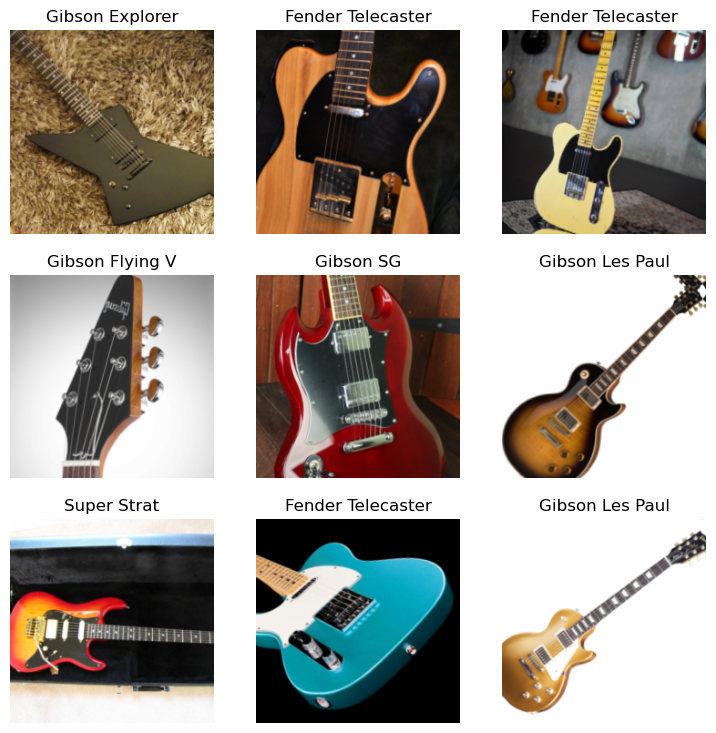

In [138]:
dls.show_batch()

## Step 4: Build & Train the model

In [139]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

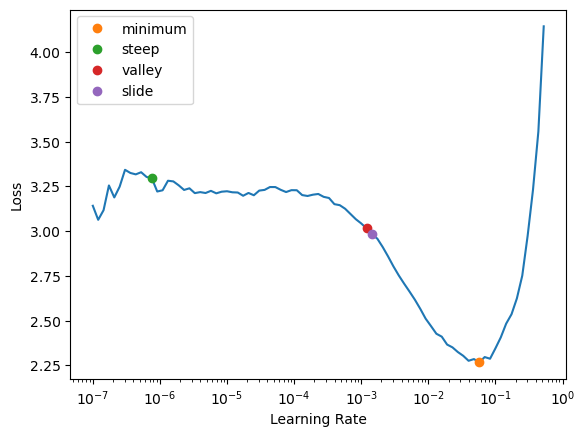

In [120]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [140]:
learn.fine_tune(6, 1e-2, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,1.703088,0.596125,0.826291,00:47
1,1.091412,0.542598,0.847418,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.593220,0.461989,0.833333,00:48
1,0.536566,0.662474,0.833333,00:47
2,0.456234,0.367233,0.880282,00:47
3,0.357247,0.212228,0.927230,00:48
4,0.261213,0.205467,0.931925,00:47
5,0.202002,0.213542,0.934272,00:48


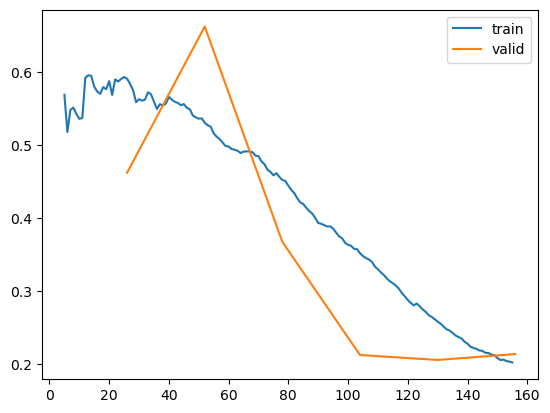

In [141]:
learn.recorder.plot_loss()

#### Using The Model to Clean the Data

In [123]:
interp = ClassificationInterpretation.from_learner(learn)

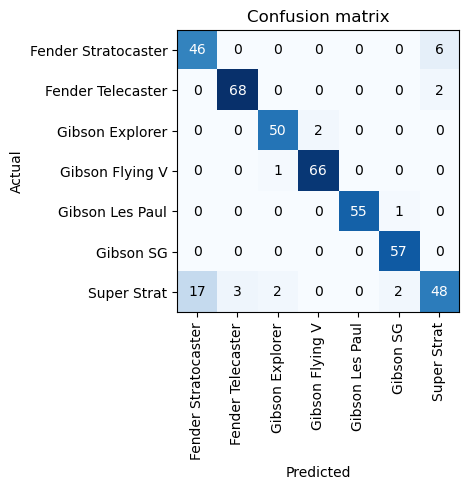

In [124]:
interp.plot_confusion_matrix()

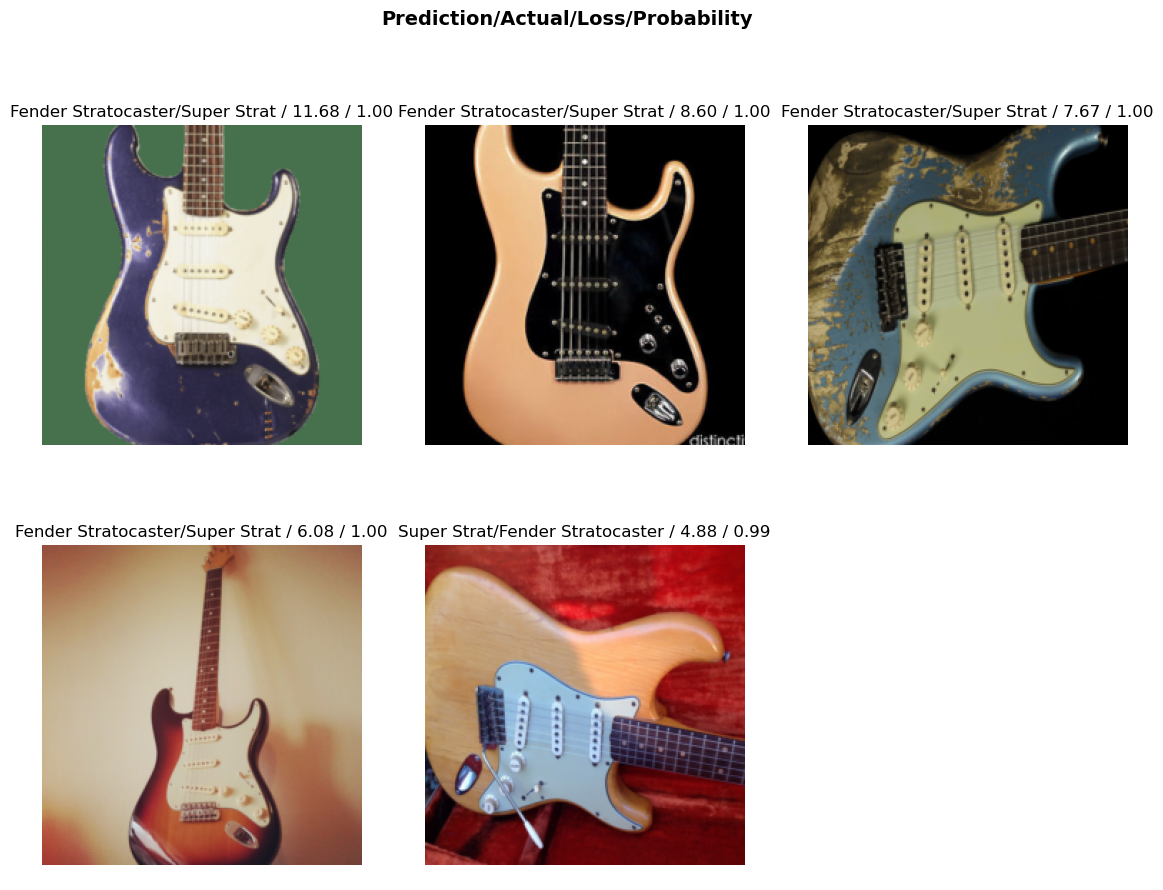

In [125]:
interp.plot_top_losses(5, nrows=2, figsize=(14,10))

In [100]:
import gc
def report_gpu():
    gc.collect()
    torch.cuda.empty_cache()

report_gpu()

In [101]:
from fastai.vision.widgets import *

In [102]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [103]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Step 5: Deploy the model